1.导包

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import re
import jieba
import jieba.analyse
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
#设置seaborn样式
sns.set(style='whitegrid')
#自定义颜色方案
color_palette={
    '正面': '#4CAF50',  # 绿色
    '负面': '#F44336',  # 红色
    '主题色1': '#2196F3',  # 蓝色
    '主题色2': '#FF9800',  # 橙色
    '主题色3': '#9C27B0',  # 紫色
    '主题色4': '#00BCD4',  # 青色
    '主题色5': '#FFEB3B',  # 黄色
}

2.读取数据

In [3]:
wk = pd.read_csv(r'C:\Users\26424\Downloads\wukong.csv')

In [4]:
wk.head()

,用户,用户链接,发布时间(2024年),是否推荐,大圣游戏时长,评论
0,Solaire,https://steamcommunity.com/profiles/7656119812...,8月20日,推荐,10.5,\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t开服前：最多3天必定拿下...
1,洪七公,https://steamcommunity.com/profiles/7656119835...,8月19日,推荐,13.2,\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t一从大地起风雷，便有精生...
2,上条利露,https://steamcommunity.com/profiles/7656119810...,8月19日,推荐,6.9,\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t我曾在莫哈维的沙漠当过邮...
3,sadness,https://steamcommunity.com/profiles/7656119814...,8月19日,推荐,21.1,\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t回想四年前的今天，如同梦...
4,xxxibgdrgn,https://steamcommunity.com/id/xxxibgdrgn5421/,8月19日,推荐,3.5,\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t你曾在西奈沙漠骑过战马；...


In [5]:
wk.describe([.99])

,大圣游戏时长
count,15869.000000
mean,9.760029
std,5.712402
min,0.100000
50%,9.300000
99%,22.432000
max,127.200000


In [14]:
wk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15861 entries, 0 to 15868
Data columns (total 8 columns):
用户             15861 non-null object
用户链接           15861 non-null object
发布时间(2024年)    15861 non-null datetime64[ns]
是否推荐           15861 non-null object
大圣游戏时长         15861 non-null float64
评论             15861 non-null object
评测情感           15861 non-null object
游戏时长分组         15861 non-null category
dtypes: category(1), datetime64[ns](1), float64(1), object(5)
memory usage: 1007.0+ KB


#数据预处理

#通过head观看前几条数据发现评论出现前面重复乱码现象需要处理
#通过describe查看数据分布发现max值较大但我认为数据合理无需处理
#通过info发现发布时间为object类型需要转为时间类型，无空值

In [7]:
#处理评论数据
wk['评论'] = wk['评论'].str.replace(r'^(\n\t)+', '')
wk['评论'] = wk['评论'].str.replace(r'^(\t)+', '')

In [8]:
#删除重复值值，删除了两行完全相同的数据
wk= wk.drop_duplicates()

In [9]:
#将发布时间的数据类型改为时间类型
wk['发布时间(2024年)'] = pd.to_datetime(wk['发布时间(2024年)'],format='%m月%d日')
wk['发布时间(2024年)'] = wk['发布时间(2024年)'].apply(lambda x: x.replace(year=2024))

In [10]:
#添加评测情感标签（根据评测标签判断）
wk['评测情感'] = wk['是否推荐'].apply(lambda x:'正面' if x == '推荐' else'负面')

In [11]:
#添加游戏时长分组
labels=['0-5小时','5-10小时','10-15小时','15-20小时','更多']
bins=[0,5,10,15,20,np.inf]
wk['游戏时长分组'] = pd.cut(wk['大圣游戏时长'],bins=bins,labels=labels )

In [12]:
wk.head()

,用户,用户链接,发布时间(2024年),是否推荐,大圣游戏时长,评论,评测情感,游戏时长分组
0,Solaire,https://steamcommunity.com/profiles/7656119812...,2024-08-20,推荐,10.5,开服前：最多3天必定拿下杨戬开服打完第1个小boss：今天先拿下虎先锋吧开服后4小时：兄弟们...,正面,10-15小时
1,洪七公,https://steamcommunity.com/profiles/7656119835...,2024-08-19,推荐,13.2,一从大地起风雷，便有精生白骨堆。僧是愚氓犹可训，妖为鬼蜮必成灾。金猴奋起千钧棒，玉宇澄清万里...,正面,10-15小时
2,上条利露,https://steamcommunity.com/profiles/7656119810...,2024-08-19,推荐,6.9,我曾在莫哈维的沙漠当过邮差，在波士顿的废土捡过垃圾，在凯尔·莫罕当过猎魔人，在星系间当过土矿...,正面,5-10小时
3,sadness,https://steamcommunity.com/profiles/7656119814...,2024-08-19,推荐,21.1,回想四年前的今天，如同梦一场。 扮演龙裔、猎魔人、刺客、勇者等等都很好，但你说可以当猴哥？这...,正面,更多
4,xxxibgdrgn,https://steamcommunity.com/id/xxxibgdrgn5421/,2024-08-19,推荐,3.5,你曾在西奈沙漠骑过战马；在欧洲海洋当过海盗；在美国经历战火纷飞；在埃及做过无声刺客。最终，你...,正面,0-5小时


#1.评论情感分析
1. 评测情感分析
正面评测数量: 13283
负面评测数量: 2578
正面评测比例: 83.75%

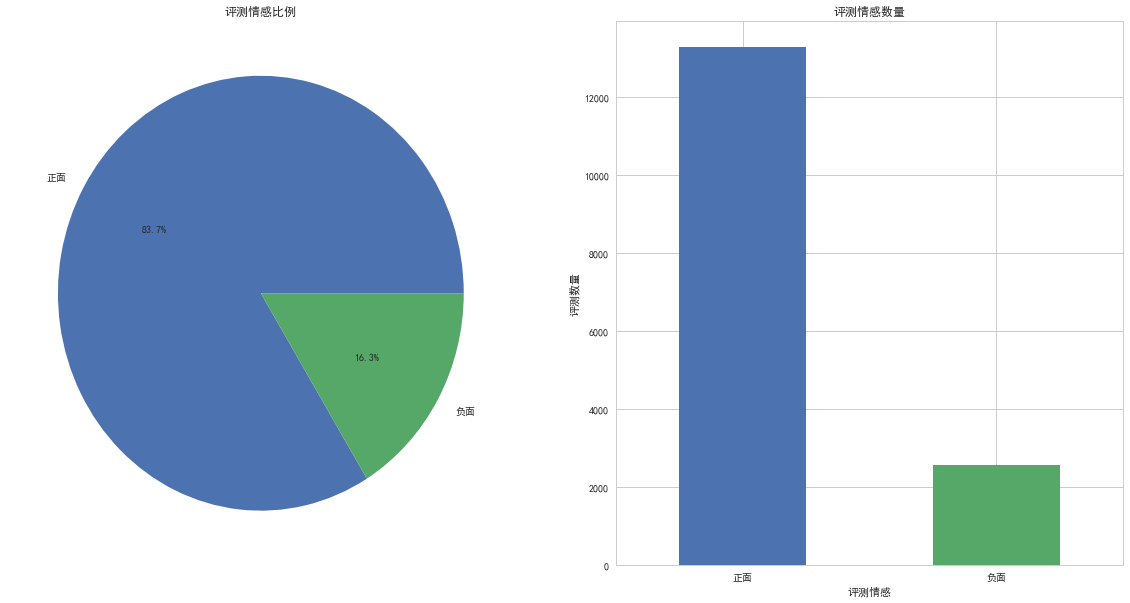

In [18]:
ed = wk['评测情感'].value_counts()
plt.figure(figsize=(20,10))
plt.subplot(121)
wk['评测情感'].value_counts().plot(kind='pie',autopct='%.1f%%',labels=ed.index)
plt.title('评测情感比例')
plt.ylabel('')
plt.subplot(122)
wk['评测情感'].value_counts().plot(kind='bar')
plt.title('评测情感数量')
plt.xlabel('评测情感')
plt.ylabel('评测数量')
plt.xticks(rotation=0)
plt.show()

In [ ]:
#2.游戏时长分析
2. 游戏时长分析
平均游戏时长: 9.76 小时
最长游戏时长: 127.2 小时
最短游戏时长: 0.10 小时
游戏时长中位数: 9.30 小时

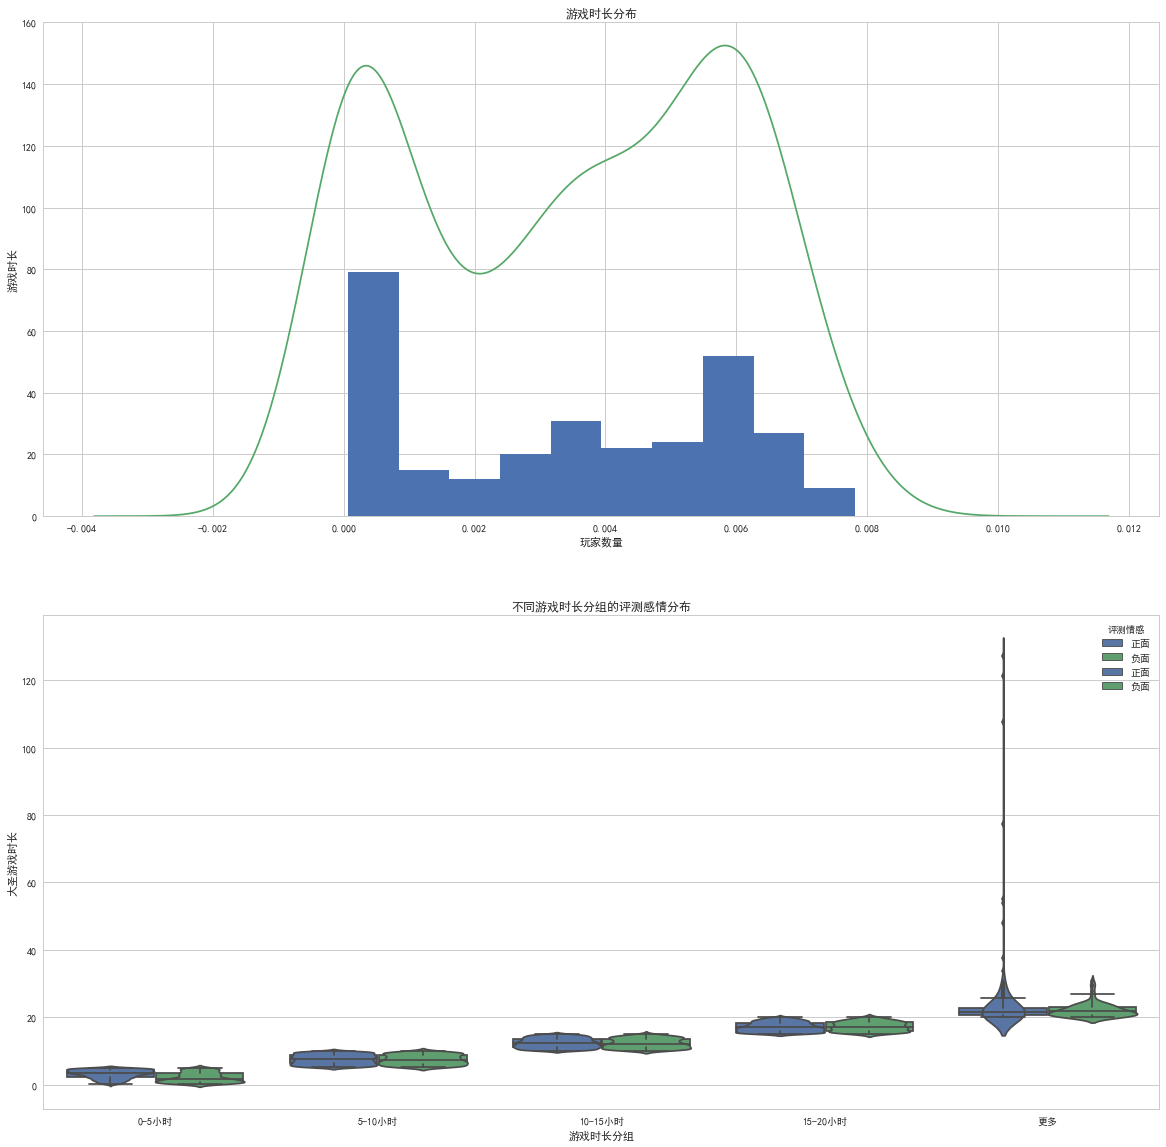

In [25]:
date = wk['大圣游戏时长'].value_counts()/wk['大圣游戏时长'].count()
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.hist((wk['大圣游戏时长'].value_counts()/wk['大圣游戏时长'].count()))
kde=pd.Series(date).plot(kind='kde',label='游戏时长_小时')
plt.title('游戏时长分布')
plt.xlabel('玩家数量')
plt.ylabel('游戏时长')
plt.xticks(rotation=0)
plt.subplot(212)
plt.title('不同游戏时长分组的评测感情分布')
sns.boxplot(
    x='游戏时长分组', 
    y='大圣游戏时长', 
    hue='评测情感',
    data=wk,
)
sns.violinplot(
    x='游戏时长分组', 
    y='大圣游戏时长', 
    hue='评测情感',
    data=wk,
    inner=None,
)

In [28]:
#3. 评测内容关键词分析
positive_reviews = wk[wk['评测情感'] == '正面']['评论'].dropna().tolist()
positive_reviews = [str(review) for review in positive_reviews]
positive_text = ' '.join(positive_reviews)
positive_keywords = jieba.analyse.extract_tags(positive_text, topK=20, withWeight=True)
print("正面评测关键词:")
for keyword, weight in positive_keywords:
    print(f"{keyword}: {weight:.4f}")

正面评测关键词:
游戏: 0.1441
好玩: 0.0858
game: 0.0734
神话: 0.0363
boss: 0.0358
3A: 0.0340
玩家: 0.0308
国产: 0.0307
大圣: 0.0290
10: 0.0277
悟空: 0.0256
战斗: 0.0231
地图: 0.0228
but: 0.0215
体验: 0.0199
游科: 0.0197
like: 0.0191
剧情: 0.0184
2024: 0.0184
优化: 0.0179


In [29]:
negative_reviews = wk[wk['评测情感'] == '负面']['评论'].dropna().tolist()
negative_reviews = [str(review) for review in negative_reviews]
negative_text = ' '.join(negative_reviews)
negative_keywords = jieba.analyse.extract_tags(negative_text, topK=20, withWeight=True)
print("\n负面评测关键词:")
for keyword, weight in negative_keywords:
    print(f"{keyword}: {weight:.4f}")


负面评测关键词:
游戏: 0.1563
boss: 0.0841
幽魂: 0.0613
地图: 0.0524
game: 0.0481
闪退: 0.0472
玩家: 0.0412
还给: 0.0389
优化: 0.0307
差评: 0.0303
没有: 0.0300
体验: 0.0299
空气: 0.0279
剧情: 0.0263
BOSS: 0.0261
闪避: 0.0221
就是: 0.0216
但是: 0.0211
问题: 0.0205
but: 0.0194


Text(0,0.5,'关键词')

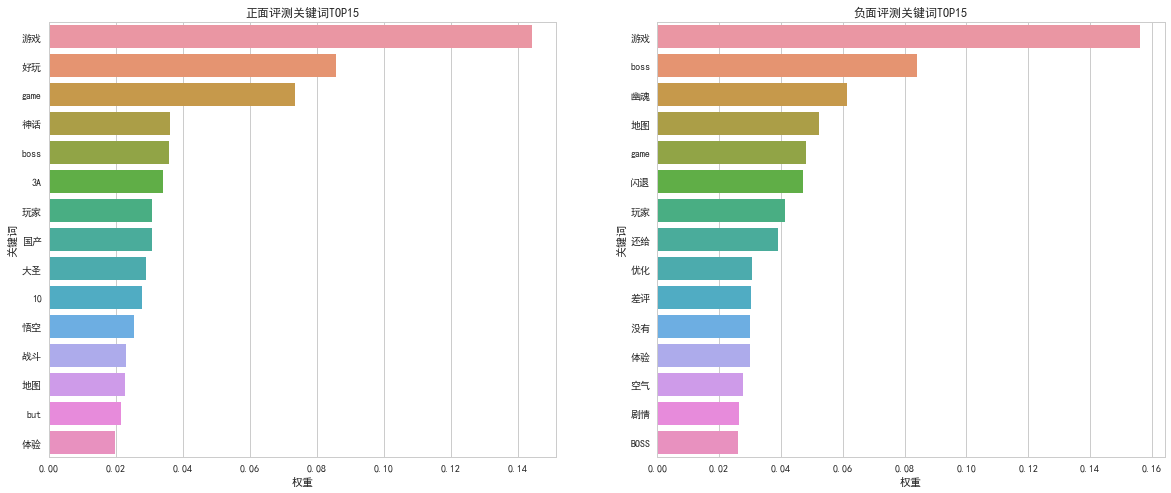

In [34]:
plt.figure(figsize=(20,8))
plt.subplot(121)
positive_wk = pd.DataFrame(positive_keywords, columns=['keyword', 'weight'])
sns.barplot(
    x='weight', 
    y='keyword', 
    data=positive_wk.sort_values('weight', ascending=False).head(15),
)
plt.title('正面评测关键词TOP15')
plt.xlabel('权重')
plt.ylabel('关键词')
plt.subplot(122)
negative_wk = pd.DataFrame(negative_keywords, columns=['keyword', 'weight'])
sns.barplot(
    x='weight', 
    y='keyword', 
    data=negative_wk.sort_values('weight', ascending=False).head(15),
)

plt.title('负面评测关键词TOP15')
plt.xlabel('权重')
plt.ylabel('关键词')

In [62]:
# 4. 评测时间分布分析
wk['评测日期_日'] = wk['发布时间(2024年)'].dt.day
daily_reviews = wk.groupby(['评测日期_日']).size().reset_index(name='评测数量')

Text(0,0.5,'评测数量')

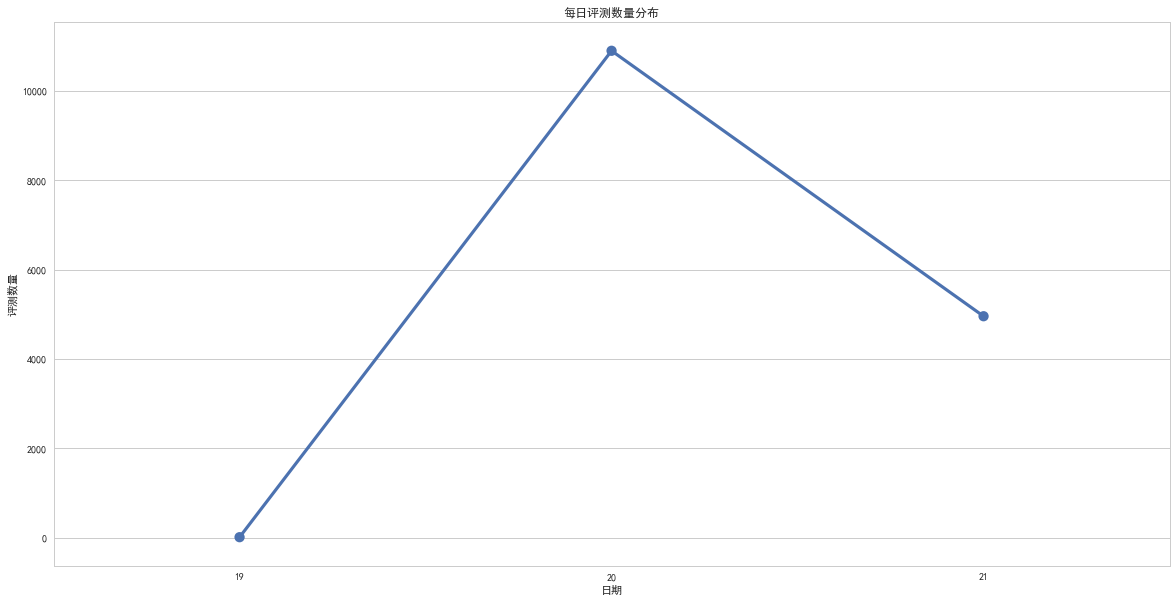

In [64]:
plt.figure(figsize=(20,10))
sns.pointplot(
    x='评测日期_日', 
    y='评测数量', 
    data=daily_reviews,
)
plt.title('每日评测数量分布')
plt.xlabel('日期')
plt.ylabel('评测数量')

In [ ]:
###
总结分析结果
根据脚本运行结果和生成的图表，我对《黑神话悟空》的Steam评测数据进行了全面分析，现从六个维度进行详细总结：

1. 评测情感分析
数据要点：
正面评测数量: 13283
负面评测数量: 2578
正面评测比例: 83.75%
分析结论：
《黑神话悟空》获得了极高的正面评价比例，超过84%的用户给予了好评。这一比例远高于Steam平台游戏的平均好评率（约70%），
表明该游戏在目标受众中取得了显著成功。如此高的好评率通常意味着游戏核心体验与玩家期望高度匹配，游戏质量和内容满足了玩家需求。

2. 游戏时长分析
数据要点：
平均游戏时长: 9.76 小时 
最长游戏时长: 127.2 小时
最短游戏时长: 0.10 小时 
游戏时长中位数: 9.30 小时
分析结论：
游戏时长数据显示这是一款高等规模的游戏作品。平均时长与中位数接近（9.76vs9.30小时），说明大多数玩家的游戏时间分布较为集中，
体验较为一致。最长游戏时长达127.2小时表明部分玩家对游戏有深度探索或多次重玩的行为，这通常是游戏具有较高回放价值的标志。

3. 评测内容关键词分析
数据要点：

正面评测关键词：游戏: 0.1441
好玩: 0.0858
game: 0.0734
神话: 0.0363
boss: 0.0358
3A: 0.0340
玩家: 0.0308
国产: 0.0307
大圣: 0.0290
10: 0.0277
悟空: 0.0256
战斗: 0.0231
地图: 0.0228
but: 0.0215
体验: 0.0199
游科: 0.0197
like: 0.0191
剧情: 0.0184
2024: 0.0184
优化: 0.0179
负面评测关键词：游戏: 0.1563
boss: 0.0841
幽魂: 0.0613
地图: 0.0524
game: 0.0481
闪退: 0.0472
玩家: 0.0412
还给: 0.0389
优化: 0.0307
差评: 0.0303
没有: 0.0300
体验: 0.0299
空气: 0.0279
剧情: 0.0263
BOSS: 0.0261
闪避: 0.0221
就是: 0.0216
但是: 0.0211
问题: 0.0205
but: 0.0194
分析结论：
关键词分析揭示了游戏的核心特点和争议点：

正负面评测中共同出现的高频词（game、剧情）表明这些元素是游戏的核心，也是评价分歧的焦点
"3A"和"体验"在正面评测中权重较高，说明这些可能是游戏的亮点
负面评测中"问题"、"差评"等情绪化词汇比例较高，表明部分玩家对游戏有负面情绪反应
"闪避"在负面评测中权重较高，可能表明游戏的闪避机制是部分玩家不满的来源
总体而言，游戏的叙事内容（剧情、角色、结局）是评价的主要依据。

4. 评测时间分布分析
数据要点：
所有15861条评测均发布于8月，游戏近期发布的，很正常

综合结论
综合六个维度的分析，《黑神话悟空》展现出以下特点：

高受欢迎度：84%以上的正面评价率表明游戏获得了玩家的广泛认可

发布时间集中：评测高度集中在8月，表明游戏可能是近期发布